In [1]:
from pathlib import Path

import marimo as mo
from openai.types.chat.chat_completion_tool_param import ChatCompletionToolParam
from openai.types.responses import (
    EasyInputMessageParam,
    ResponseFunctionToolCallParam,
)
from openai.types.responses.response_input_param import FunctionCallOutput

from eval_recipes.evaluate import evaluate
from eval_recipes.schemas import BaseEvaluatorConfig
from eval_recipes.evaluations.claim_verification.claim_verification_evaluator import ClaimVerificationEvaluatorConfig
from eval_recipes.evaluations.tool_usage.tool_usage_evaluator import ToolUsageEvaluatorConfig
from eval_recipes.evaluations.guidance.guidance_evaluator import GuidanceEvaluatorConfig

# Assistant Evaluations

Evaluating LLM-based *applications* is hard, this package aims to make it easier, while giving you the flexbility to customize for your unique needs.

When you see the word "evaluations" in the context of LLMs it could refer to a few things [1]:

1. Industry benchmarks for comparing models in isolation, like [MMLU](https://github.com/openai/evals/blob/main/examples/mmlu.ipynb), [ARC-AGI](https://github.com/arcprize/ARC-AGI-2), and those listed on [HuggingFace's leaderboard](https://huggingface.co/collections/open-llm-leaderboard/the-big-benchmarks-collection-64faca6335a7fc7d4ffe974a)
2. Industry benchmarks for comparing specific portions of a system, like memory (ex. [LongMemEval](https://github.com/xiaowu0162/LongMemEval)) or agentic software engineering tasks (ex. [SWE Bench Verified](https://huggingface.co/datasets/princeton-nlp/SWE-bench_Verified)).
3.  Standard numerical scores like [ROUGE](https://aclanthology.org/W04-1013/) or [BERTScore](https://arxiv.org/abs/1904.09675)
4. Specific tests you implement to measure your LLM application's performance.

This package is about the last type: providing a set of common "tests" to measure your application's performance. We refer to these as **online evaluations** or **telemetry** as they are scores that computed as your application runs, without the need for explict labeled data.
In this notebook, we show the four core evaluations we provide: claim verification[2], measuring if user preferences are adhered to, does the assistant provide proper guidance when needed, and does it use tools effectively.

The differences between our evaluations and other open source evaluation frameworks are:

1. None of our evaluations require any labeled data or criteria specific to a scenario. This enables it to provide signals over novel and messy user scenarios without relying on collecting human labels which are brittle, subjective, and expensive to collect.
2. We implement workflows, not simple LLM-as-a-Judge prompts. For example, detecting if user preferences are adhered to is a multi-step process that first extracts user preferences, then validates each of them individually against the conversation history.
3. The inputs to each evaluator (our evaluations operate over messages and tool definitions) match one-to-one to the inputs that generated the outputs. This makes it easy to apply and ensures the same context is being considered in the evaluation.

## Use Cases
There are three core use cases.

1. After deployment, monitoring and telemetry.
2. Before deployment, testing two different systems against each other. For example, when changing the model used.
3. Generating data for model training. For example, one could use the claim verification evaluation outputs to rewrite a response to remove the detected hallucinations.

[1] [Evals design best practices - OpenAI](https://platform.openai.com/docs/guides/evals-design?api-mode=responses#what-are-evals).

[2] Our claim verification evaluation is based on the following two papers: [Claimify](https://arxiv.org/abs/2502.10855) and [VeriTrail](https://arxiv.org/abs/2505.21786). It is not an official implementation of either and please cite the original papers if you use this evaluation in your work.

# High Level API

Assistant evaluations exposes one high level function, `evaluate`, which expects the inputs you are already likely using in your assistant: chat messages and tool definitions. Specifically, we use the same parameters as the [OpenAI Responses API](https://platform.openai.com/docs/api-reference/responses/create#responses_create-input). We chose this because it is likely what you are already using and it is a common standard even for other LLM providers to support. It is also straighforward to write your own conversion from any other message and tool types.

Html()
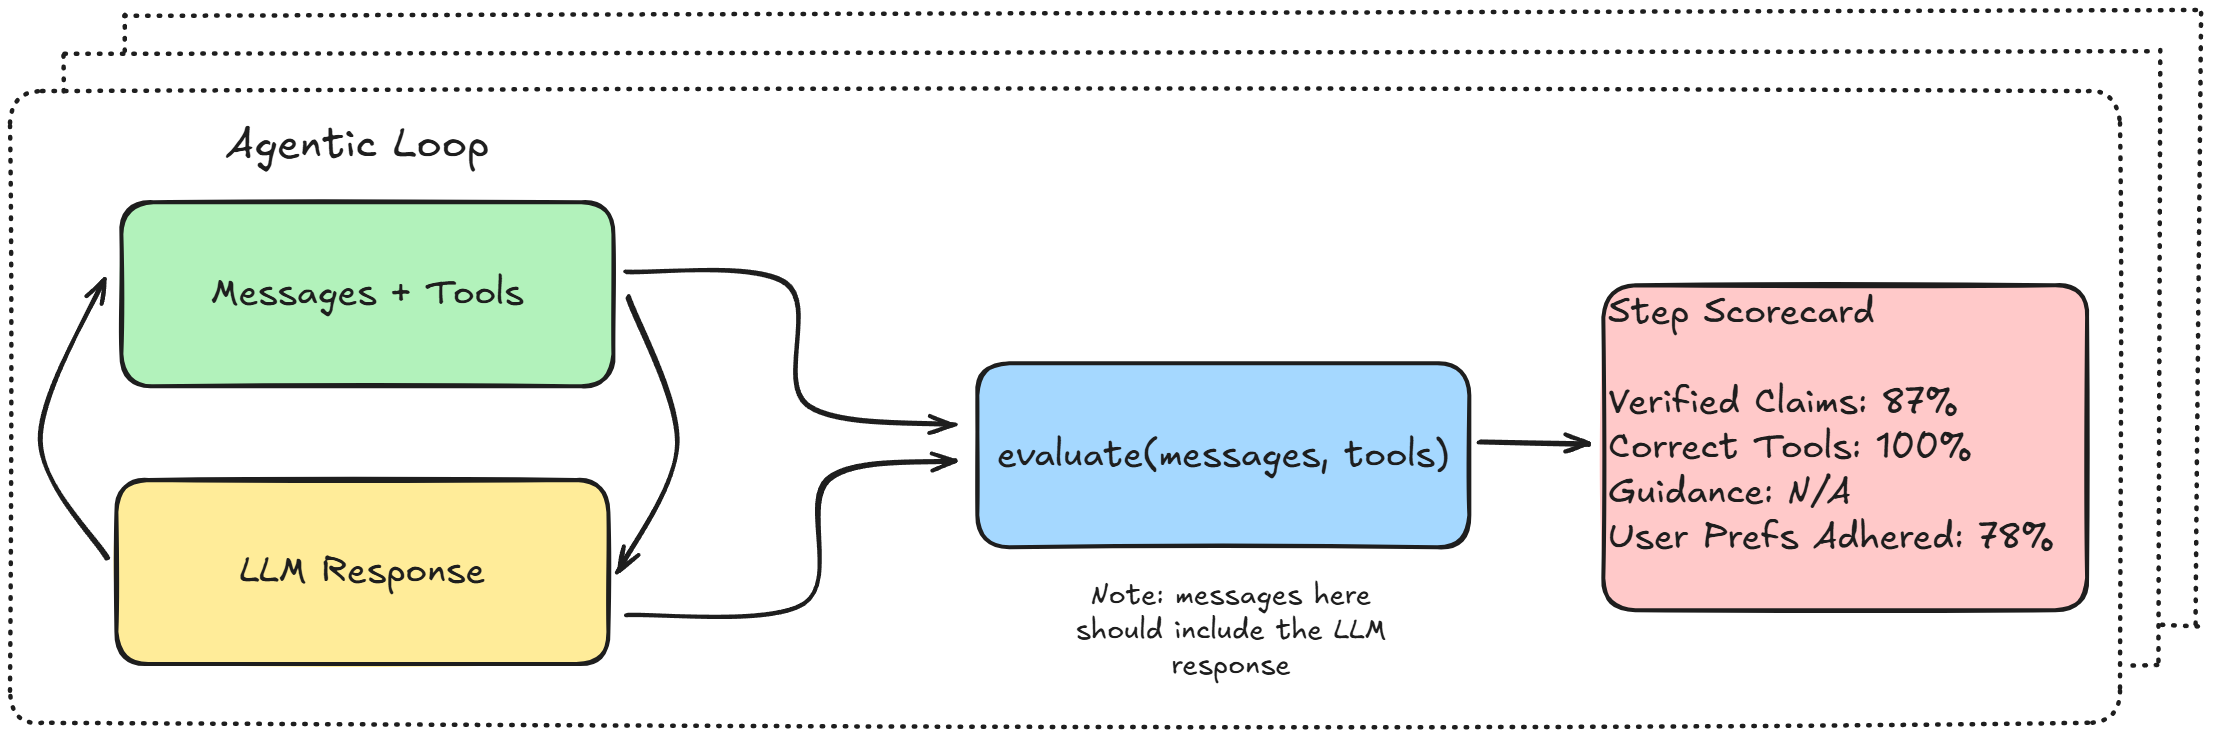

In [2]:
# Handle both .py and .ipynb environments
try:
    # In marimo environment, __file__ is available
    __file__
    image_path = "demos/data/Evaluate API Diagram.png"
except NameError:
    # Fallback for Jupyter notebooks - use path relative to current directory
    image_path = "data/Evaluate API Diagram.png"

mo.image(image_path)

## Example Scenario

In the following cell, we define an example scenario. Since the contents are lengthy, we describe it in words here:

1. The system prompt encourages the model to call tools, contains a memories, and the assistant is provided with 4 core tools around search and file viewing/editing.
2. The user has uploaded a file called "Earnings Release FY24 Q4.md" which contains Microsoft's financial data from that quarter.
3. They ask for the assistant to read the file and asks for the key metrics.
4. The assistant calls the `ls` tool to find the exact file path and then uses the `view` tool to read it
5. Finally, the textbox below is a hypothetical message that an assistant can generate. **Note these two important aspects about the default response** for when we look at the final results:
    * The responses is bulleted list form, while there is a user memory in the system prompt that suggests to use paragraphs instead
    * The responses contains an intentional factual inaccuracy where one of the financial figures was changed from 22.0B to 15.0B.

Try to change the response to see how it changes the evaluation results!

In [3]:
SYSTEM_PROMPT = """You are an autonomous agent that helps users get their work done. \
You will be provided a set of tools that you should use to gather context and take actions appropriately according to the user's intent. \
You will be provided memories from previous interactions with the user which you should abide by, unless within the context of this conversation it is not appropriate.

<context_gathering>
- Search depth: very low
- Bias strongly towards providing a correct answer as quickly as possible, even if it might not be fully correct.
- Usually, this means an absolute maximum of 2 tool calls.
- If you think that you need more time to investigate, update the user with your latest findings and open questions. You can proceed if the user confirms.
</context_gathering>

<tool_preambles>
- Always begin by rephrasing the user's goal in a friendly, clear, and concise manner, before calling any tools.
- Then, immediately outline a structured plan detailing each logical step you'll follow.
- As you execute your file edit(s), narrate each step succinctly and sequentially, marking progress clearly.
- Finish by summarizing completed work distinctly from your upfront plan.
</tool_preambles>

<memories>
- The user prefers responses in paragraph form
</memories>"""

CAPABILITY_MANIFEST = """# Overview
This assistant can work with files available to it, create or edit documents, read file contents, and search for information using the provided tools. \
Its capabilities are limited to what the tools explicitly support and the ability to return textual answers using Markdown syntax

## File Operations

CAN
- Use ls to list the files that you can view.
- Use view to read the contents of a file at the specified path.
- Use edit_file to create or edit documents.
- Extract and summarize information from files it can read (for example, key metrics in an earnings release).

CANNOT
- Access or read files that are not listed by ls or otherwise not within the accessible file scope.
- Delete, move, rename, or copy files or folders (no tool is provided for these operations).
- Execute or run files, scripts, or programs (no execution tools are provided).
- Guarantee readability of non-text or unsupported formats; if view cannot return readable contents (e.g., binary or protected files), the assistant cannot process them.
- Access external storage locations (e.g., cloud drives, email attachments) unless their files are present in the accessible file list.

## Data Processing

CAN
- Read and interpret text returned by view.
- Identify, extract, and summarize key metrics and facts present in a document (e.g., revenue, EPS, guidance) when they are explicitly stated in the text.
- Perform straightforward comparisons and simple calculations based on the text it can read.

CANNOT
- Infer or fabricate data that is not present in the viewed content or user-provided context.
- Parse or analyze content that is not retrievable as readable text via view.
- Perform code execution, data transformation, or advanced analytics beyond text-based reasoning and summarization (no computation or execution tools are provided).

## Search and External Information

CAN
- Use search to search for information.

CANNOT
- Browse specific URLs, click links, or navigate web pages (no browsing or fetching tool is provided).
- Download external files or ingest web content directly into the file workspace.
- Access real-time or paywalled data sources beyond what search returns via its own interface.

## Writing and Reporting

CAN
- Generate textual summaries, key takeaways, and bullet lists.
- Use edit_file to create or edit documents containing extracted metrics, summaries, notes, or reports.

CANNOT
- Produce or export files in formats or locations not supported by edit_file.
- Guarantee specific document layouts or complex formatting beyond what edit_file supports.

## Interaction and Task Flow

CAN
- Ask for clarification or a file path if the target document (e.g., an earnings release) is not identifiable via ls.
- Propose a plan: use ls to discover candidate files, view to inspect contents, then summarize key metrics, and optionally use edit_file to produce a written report.

CANNOT
- Proceed with file analysis if the needed file is not accessible via ls/view.
- Confirm the existence of a file without checking via ls or receiving the exact path from the user.

## Constraints and Assumptions

- Tool capabilities are limited to their explicit definitions:
  - search: Search for information
  - edit_file: Create or edit documents
  - ls: List the files that you can view
  - view: Read the contents of a file at the specified path
- The assistant's ability to analyze any document depends on successful retrieval of readable content via view.
- Absence of tools for deletion, movement, renaming, code execution, web browsing, downloading, or uploading implies those actions are not supported.
"""

SEARCH_TOOL = ChatCompletionToolParam(
    type="function",
    function={
        "name": "search",
        "description": "Search for information",
        "parameters": {
            "type": "object",
            "properties": {"query": {"type": "string"}},
            "required": ["query"],
        },
    },
)

EDIT_TOOL = ChatCompletionToolParam(
    type="function",
    function={
        "name": "edit_file",
        "description": "Create or edit documents",
        "parameters": {
            "type": "object",
            "properties": {
                "path": {"type": "string"},
                "content": {"type": "string"},
            },
            "required": ["path", "content"],
        },
    },
)

LS_TOOL = ChatCompletionToolParam(
    type="function",
    function={
        "name": "ls",
        "description": "List the files that you can view",
        "parameters": {
            "type": "object",
            "properties": {
                "path": {
                    "type": "string",
                    "description": "relative path to the root",
                }
            },
            "required": ["path"],
        },
    },
)

VIEW_TOOL = ChatCompletionToolParam(
    type="function",
    function={
        "name": "view",
        "description": "Read the contents of a file at the specified path",
        "parameters": {
            "type": "object",
            "properties": {
                "path": {
                    "type": "string",
                    "description": "The path to the file to read (e.g., '/docs/file.txt')",
                }
            },
            "required": ["path"],
        },
    },
)

USER_MESSAGE = "Can you load the earnings release file and tell me the key metrics?"

ASSISTANT_MESSAGE_1 = "You're asking me to load your earnings release file and extract the key metrics. My plan is to first locate the earnings release file in your workspace, then open it to identify and summarize key metrics like revenue, EPS, guidance, segment performance, and any notable YoY/QoQ changes. I will start by listing the directories to find the file, then open the most likely match, and finally present a concise summary of the metrics.\n\nStep 1: I will list the top-level directories to locate the earnings release file."

FUNCTION_CALL_1 = ResponseFunctionToolCallParam(
    {
        "type": "function_call",
        "call_id": "call_1",
        "name": "ls",
        "arguments": "{'path': '/'}",
    }
)

FUNCTION_CALL_OUTPUT_1 = FunctionCallOutput(
    {
        "type": "function_call_output",
        "call_id": "call_1",
        "output": "{'files': ['Earnings Release FY24 Q4.md']}",
    }
)

FUNCTION_CALL_2 = ResponseFunctionToolCallParam(
    {
        "type": "function_call",
        "call_id": "call_2",
        "name": "view",
        "arguments": "{'path': 'Earnings Release FY24 Q4.md'}",
    }
)

# Handle both .py and .ipynb environments
import sys

try:
    data_path = Path(__file__).parents[0] / "data" / "Earnings Release FY24 Q4.md"
except NameError:
    # Fallback for Jupyter notebooks - use current working directory
    data_path = Path.cwd() / "data" / "Earnings Release FY24 Q4.md"

FILE_CONTENT = data_path.read_text(encoding="utf-8")

FUNCTION_CALL_OUTPUT_2 = FunctionCallOutput(
    {
        "type": "function_call_output",
        "call_id": "call_2",
        "output": str({"file_content": FILE_CONTENT}),
    }
)

# Net income was intentionally made to be 15B instead of 22B
DEFAULT_ASSISTANT_MESSAGE = """Here are the key metrics from the FY24 Q4 earnings release:
- Quarterly Revenue: $64.7B, up 15%
- Operating Income: $27.9B, up 15%
- Net Income: $15.0B, up 10%
- Diluted EPS: $2.95, up 10%"""

final_assistant_message = mo.ui.text_area(
    label="The will be the final assistant message, which is the focus of the evaluation.",
    value=DEFAULT_ASSISTANT_MESSAGE,
    full_width=True,
)
final_assistant_message

text_area()

In [4]:
messages = [
    EasyInputMessageParam(role="system", content=SYSTEM_PROMPT),
    EasyInputMessageParam(role="user", content=USER_MESSAGE),
    EasyInputMessageParam(role="assistant", content=ASSISTANT_MESSAGE_1),
    FUNCTION_CALL_1,
    FUNCTION_CALL_OUTPUT_1,
    FUNCTION_CALL_2,
    FUNCTION_CALL_OUTPUT_2,
    EasyInputMessageParam(role="assistant", content=final_assistant_message.value),
]

tools: list[ChatCompletionToolParam] = [SEARCH_TOOL, EDIT_TOOL, LS_TOOL, VIEW_TOOL]

## Evaluation Configuration

Each evaluation can be configured with specific parameters to control its behavior. All evaluations inherit from `BaseEvaluationConfig` and add their own specific parameters.


### Base Configuration

All evaluations share these common configuration parameters:

- **`provider`** (`"openai"` | `"openai"`): The LLM provider to use for evaluation.
- **`model`** (`"gpt-5"` | `"gpt-5-mini"` | `"gpt-5-nano"` | `"o3"` | `"o4-mini"`): The model to use for evaluation.


### Preference Adherence (`BaseEvaluationConfig`)

Uses only the base configuration parameters (`provider` and `model`).


### Claim Verification (`ClaimVerifierConfig`)

- **`claim_extraction_model`**: The model used to extract claims from text. A smaller, faster model is often sufficient. Default: `"gpt-5-mini"`
- **`verification_model`**: The model used to verify each extracted claim against source context. Default: `"gpt-5"`
- **`verification_reasoning_effort`**: The reasoning effort level for verification. It is important that verification is accurate, so using the most capable model is recommended.
- **`max_line_length`** (`int`): Maximum character length per line when formatting source documents. Lines longer than this are wrapped. Default: `200`
- **`max_concurrency`** (`int`): Sets the maximum number of sentences **and** claims within a sentence that can be processed at once. Default: `1`
- **`ignore_tool_names`** (`list[str]`): List of tool names whose outputs should not be used as source context for verification. Useful for excluding tools that return LLM generated content such as generated documents.


### Guidance Evaluation (`GuidanceEvaluationConfig`)

- **`capability_manifest`**: A description of the assistant's capabilities. This should detail what the assistant can and cannot do. If not provided, it will be auto-generated each time (computationally expensive). **Highly recommended to pre-compute.**
- **`in_scope_probability_threshold`** (`float`): The probability threshold (0-100) above which a request is considered within scope. If the probability that a request is in-scope exceeds this threshold, the guidance evaluation is deemed not applicable.


### Tool Usage Evaluation (`ToolEvaluationConfig`)

- **`tool_thresholds`** (`dict[str, float]`): A dictionary mapping tool names to probability thresholds (0-100). Each threshold indicates the minimum probability at which that specific tool should be called. If a tool's calculated probability exceeds its threshold, it should have been called.

In [5]:
preference_adherence_config = BaseEvaluatorConfig(model="gpt-5")

claim_verification_config = ClaimVerificationEvaluatorConfig(
    claim_extraction_model="gpt-5",
    provider="openai",
    verification_model="gpt-5",
    verification_reasoning_effort="medium",
    ignore_tool_names=["edit_file"],
    max_concurrency=10,
)

guidance_config = GuidanceEvaluatorConfig(
    provider="openai",
    model="gpt-5",
    capability_manifest=CAPABILITY_MANIFEST,
)

tool_usage_config = ToolUsageEvaluatorConfig(
    tool_thresholds={
        "search": 55,
        "edit_file": 60,
    }
)

## Evaluate

`evaluate` will call each individual evaluation you provide in `evaluations`.

```python
async def evaluate(
    messages: ResponseInputParam,
    tools: list[ChatCompletionToolParam],
    evaluations: list[str | type[EvaluatorProtocol]],
    evaluation_configs: dict[str, BaseEvaluationConfig] = {},
    max_concurrency: int = 1,
) -> list[EvaluationOutput]:
```

And it will return a list of:

```python
class EvaluationOutput(BaseModel):
    eval_name: str
    applicable: bool
    score: float
    metadata: dict[str, Any] = {}
```

In [6]:
results = await evaluate(
    messages=messages,
    tools=tools,
    evaluations=[
        "guidance",
        "preference_adherence",
        "tool_usage",
        "claim_verification",
    ],
    evaluation_configs={
        "guidance": guidance_config,
        "tool_usage": tool_usage_config,
        "claim_verification": claim_verification_config,
        "preference_adherence": preference_adherence_config,
    },
    max_concurrency=4,
)

2025-08-29 16:47:56.155 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:run:157 - Starting claim verification


2025-08-29 16:47:56.164 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:run:165 - Split text into 1 sentences


2025-08-29 16:47:56.164 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:_process_sentence:203 - Processing sentence 1: "'Here are the key metrics from the FY24 Q4 earnings release:\n- Quarterly Revenue: $64.7B, up 15%\n- Op'..."


2025-08-29 16:48:14.954 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:98 - Selection result: has_verifiable_claims=True


2025-08-29 16:48:47.232 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:104 - Disambiguation result: 1 disambiguated sentences


2025-08-29 16:49:58.208 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:_process_sentence:110 - Decomposition result: 8 claims extracted


2025-08-29 16:49:58.208 | INFO     | eval_recipes.evaluations.claim_verification.claim_extraction:run:92 - Claim extraction complete. Total claims extracted: 8


2025-08-29 16:49:58.209 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:_process_sentence:221 - Verifying claim: Quarterly revenue was $64.7 billion [as reported in the FY24 Q4 earnings release]....


2025-08-29 16:49:58.209 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:_process_sentence:221 - Verifying claim: Quarterly revenue was up 15% [as reported in the FY24 Q4 earnings release]....


2025-08-29 16:49:58.209 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:_process_sentence:221 - Verifying claim: Operating income was $27.9 billion [as reported in the FY24 Q4 earnings release]....


2025-08-29 16:49:58.209 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:_process_sentence:221 - Verifying claim: Operating income was up 15% [as reported in the FY24 Q4 earnings release]....


2025-08-29 16:49:58.210 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:_process_sentence:221 - Verifying claim: Net income was $15.0 billion [as reported in the FY24 Q4 earnings release]....


2025-08-29 16:49:58.210 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:_process_sentence:221 - Verifying claim: Net income was up 10% [as reported in the FY24 Q4 earnings release]....


2025-08-29 16:49:58.210 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:_process_sentence:221 - Verifying claim: Diluted EPS was $2.95 [as reported in the FY24 Q4 earnings release]....


2025-08-29 16:49:58.210 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:_process_sentence:221 - Verifying claim: Diluted EPS was up 10% [as reported in the FY24 Q4 earnings release]....


2025-08-29 16:50:44.322 | INFO     | eval_recipes.evaluations.claim_verification.claim_verification_evaluator:run:180 - Claim verification complete. Total claims verified: 8


In [7]:
summary_data = []
for result in results:
    summary_data.append(
        {
            "name": result.eval_name.replace("_", " ").title(),
            "applicable": result.applicable,
            "score": result.score if result.applicable else None,
        }
    )

# Calculate average score for applicable evaluations
applicable_scores = [item["score"] for item in summary_data if item["applicable"] and item["score"] is not None]
avg_score = sum(applicable_scores) / len(applicable_scores) if applicable_scores else 0

# Build summary table rows
summary_rows = []
for eval_data in summary_data:
    applicability = "Yes" if eval_data["applicable"] else "No"
    score_display = (
        f"{eval_data['score']:.2f}%" if eval_data["applicable"] and eval_data["score"] is not None else "N/A"
    )

    summary_rows.append(f"| **{eval_data['name']}** | {applicability} | {score_display} |")

summary_table = "\n".join(summary_rows)

# Count applicable evaluations
num_applicable = sum(1 for item in summary_data if item["applicable"])
total_evals = len(summary_data)

mo.md(
    f"""
## Summary of all Evaluations Run

- **Applicable Evaluations:** *{num_applicable} out of {total_evals}*
- **Average Score:** *{avg_score:.2f}%*

| Evaluation | Applicable | Score |
|------------|------------|-------|
{summary_table}
| **Average** | N/A | {avg_score:.2f} |
---

**Note:** Because we only had one example, we are averaging across evaluations. Typically you should report across each individual evaluation first in order to analyze each evaluation dimension separately for your assistant.
The average score is calculated only from evaluations that were applicable to this example.
"""
)

Evaluation,Applicable,Score
Guidance,No,N/A
Preference Adherence,Yes,5.00%
Tool Usage,Yes,100.00%
Claim Verification,Yes,87.50%
Average,N/A,64.17
---,,


In [8]:
def render_evaluation_result(title, result, custom_details="", no_data_message="No evaluation performed."):
    """Common function to render evaluation results."""
    applicable_text = "yes" if result.applicable else "no"
    score_section = f"- **Overall Score: *{result.score:.2f}%***" if result.applicable else ""

    return f"""
## {title}

- **Is the evaluation applicable to this example? *{applicable_text}***
{score_section}
{custom_details if custom_details else f"*{no_data_message}*"}
"""


def get_result_by_name(results, eval_name):
    """Helper to get result by evaluation name."""
    return next((x for x in results if x.eval_name == eval_name), None)

In [9]:
user_prefs_result = get_result_by_name(results, "preference_adherence")

# Extract adherence details from metadata
adherence_list = user_prefs_result.metadata.get("adherence_to_preferences", [])

# Build the markdown for each preference
preference_sections = []
for idx, adherence in enumerate(adherence_list):
    preference_sections.append(f"""
**Preference {idx + 1}**: *{adherence["preference"]}*

- Reasoning: *{adherence["reasoning"]}*
- Adherence Probability: *{adherence["adherence_probability"]:.1f}%*
- Determination: *{adherence["determination"]}*""")

preferences_md = "\n---\n".join(preference_sections) if preference_sections else "No preferences evaluated."

# Build the details section only if applicable
up_details = ""
if user_prefs_result.applicable:
    up_details = f"""### Metadata

The user preference evaluation extracts preferences from the conversation and evaluates adherence to each one.
For each preference:

* The model provides reasoning about whether the preference was followed
* Generates an adherence probability (0-100%) indicating how well the preference was followed
* Makes a determination: "adhered", "did_not_adhere", or "not_applicable"

The final score is the average of adherence probabilities for applicable preferences only.

{preferences_md}"""

mo.md(
    render_evaluation_result(
        "User Preferences Results",
        user_prefs_result,
        custom_details=up_details,
        no_data_message="No preferences to evaluate or evaluation not applicable.",
    )
)

_md()

In [10]:
guidance_result = get_result_by_name(results, "guidance")

if guidance_result:
    # Extract guidance metadata
    in_scope_reasoning = guidance_result.metadata.get("in_scope_reasoning", {})
    reasoning = guidance_result.metadata.get("reasoning", "No reasoning provided.")

    # Build the detailed sections
    g_details = ""

    if in_scope_reasoning:
        g_details = f"""
### Metadata

The guidance evaluation checks how gracefully an assistant handles out-of-scope requests.
It first determines if requests are within capabilities through a multi-step reasoning process

* Capabilities Analysis: detailed reasoning about the capabilities available to accomplish the user's task
* Sufficient Capabilities: whether the available capabilities are sufficient to accomplish the user's task, including the capabilities that could be included to more efficiently or effectively accomplish the task
* In-Scope Reasoning: whether the assistant could accomplish the user's task with the available capabilities to a high degree

Then, after those reasoning steps, a probability is generated.

These were the results for this evaluation:

**Capabilities Analysis:** *{in_scope_reasoning.get("capabilities_analysis", "N/A")}*

**Sufficient Capabilities:** *{in_scope_reasoning.get("sufficient_capabilities", "N/A")}*

**In-Scope Reasoning:** *{in_scope_reasoning.get("in_scope_reasoning", "N/A")}*

**In-Scope Probability:** *{in_scope_reasoning.get("is_in_scope_probability", 0):.1f}%*

If the request was deemed to be **not** in scope, then an LLM evaluates how well the assistant handled that request."""

mo.md(
    render_evaluation_result(
        "Guidance Results",
        guidance_result,
        custom_details=g_details,
        no_data_message="No guidance evaluation performed (request was in-scope).",
    )
)

_md()

In [11]:
cv_result = get_result_by_name(results, "claim_verification")

# Extract claim verification metadata
cv_metadata = cv_result.metadata
cv_total_claims = cv_metadata.get("total_claims", 0)
cv_supported = cv_metadata.get("number_supported_claims", 0)
cv_open_domain = cv_metadata.get("number_open_domain_claims", 0)
cv_not_supported = cv_metadata.get("number_not_supported_claims", 0)
cv_claims = cv_metadata.get("claims", [])

# Build claim statistics section
cv_stats_section = ""
if cv_total_claims > 0:
    cv_stats_section = f"""
### Claim Statistics

- **Total Claims:** *{cv_total_claims}*
- **Supported Claims:** *{cv_supported}*
- **Open Domain Claims:** *{cv_open_domain}*
- **Unsupported Claims:** *{cv_not_supported}*"""

# Build individual claims section
cv_claims_sections = []
for idx_cv, claim in enumerate(cv_claims):
    # Determine verification status
    verification_status = "❌ Unsupported"
    if claim.get("citations", []):
        verification_status = "✅ Supported"
    elif claim.get("is_open_domain", False):
        verification_status = "🌐 Open Domain"

    # Build citations text
    citations_text = ""
    if claim.get("citations", []):
        citation_items = []
        for citation in claim["citations"]:
            citation_items.append(f"Source {citation['source_id']}: *{citation.get('cited_text', 'N/A')}*")
        citations_text = "\n    - " + "\n    - ".join(citation_items)

    cv_claims_sections.append(f"""**Claim {idx_cv + 1}:** *{claim.get("claim", "N/A")}*

- **Status:** {verification_status}
- **Original Sentence:**

```markdown
 {claim.get("sentence", "N/A")}
```

- **Proof:** *{claim.get("proof", "N/A") if claim.get("proof") else "No proof provided"}*
{f"- **Open Domain Justification:** *{claim.get('open_domain_justification', '')}*" if claim.get("is_open_domain") else ""}""")

cv_claims_md = "\n---\n".join(cv_claims_sections) if cv_claims_sections else "*No claims evaluated.*"

# Build the final markdown
cv_details = ""
if cv_result.applicable and cv_total_claims > 0:
    cv_details = f"""{cv_stats_section}

---

### Detailed Claim Analysis

*NOTE: Citations are not included in this output, see the dedicated notebook for more details*

{cv_claims_md}"""

mo.md(
    render_evaluation_result(
        "Claim Verification Results",
        cv_result,
        custom_details=cv_details,
        no_data_message="No claims to verify or evaluation not applicable.",
    )
)

_md()

In [12]:
tu_result = get_result_by_name(results, "tool_usage")

# Extract tool usage metadata
tu_metadata = tu_result.metadata
tu_evaluations = tu_metadata.get("tool_evaluations", {})
tu_tool_list = tu_evaluations.get("tool_evaluations", []) if isinstance(tu_evaluations, dict) else []

# Build individual tool evaluations section
tu_tool_sections = []
for idx_tu, tool_eval in enumerate(tu_tool_list):
    tool_name = tool_eval.get("tool_name", "N/A")
    tool_reasoning = tool_eval.get("reasoning", "N/A")
    tool_probability = tool_eval.get("probability", 0)

    # Determine if this tool probability indicates it should have been called
    probability_indicator = "🟢" if tool_probability >= 50 else "🔴"

    tu_tool_sections.append(f"""
**Tool {idx_tu + 1}: *{tool_name}***

- **Probability Should Be Called:** {probability_indicator} *{tool_probability:.1f}%*
- **Reasoning:** *{tool_reasoning}*""")

tu_tools_md = "\n---\n".join(tu_tool_sections) if tu_tool_sections else "*No tools evaluated.*"

# Build the final markdown
tu_details = ""
if tu_result.applicable and tu_tool_list:
    tu_details = f"""
### Tool Call Analysis

The evaluation determines the probability that each tool should have been called based on the conversation context.

- If no tools should be called (was_called=False for all)
    - Each probability should be below the threshold. If so, return 100, 0 otherwise.
- If was_called=True for any tool:
    - Check any of those tool's probability is above its threshold, if so return 100.
    Otherwise if none of the "was_called=True" have a probability over the threshold,  return 0.

{tu_tools_md}"""

mo.md(
    render_evaluation_result(
        "Tool Usage Results",
        tu_result,
        custom_details=tu_details,
        no_data_message="No tools to evaluate or evaluation not applicable.",
    )
)

_md()

In [13]:
feedback_str = ""
for f_result in results:
    if f_result.feedback:
        feedback_str += f"**{f_result.eval_name}**:\n```plaintext\n{f_result.feedback}\n```\n\n"
feedback_str.strip()

mo.md(f"""# Feedback

Each evaluation will optionally output `feedback`, which can be used to get more details about why a (typically bad) score was given. Below is the feedback for this scenario.

## Generated Feedback
{feedback_str}
""")

_md()

# Next Steps

Check out the low level APIs!